In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp "/content/gdrive/My Drive/kaggle.json" ~/.kaggle/

In [ ]:
!chmod 600 /content/gdrive/MyDrive/kaggle.json

In [ ]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

 94% 293M/312M [00:03<00:00, 107MB/s]
100% 312M/312M [00:03<00:00, 96.8MB/s]


In [ ]:
!unzip -q "/content/brain-tumor-segmentation.zip" -d "/content/dataset"

In [ ]:
#import libraries

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [ ]:
#each time we generate random number they areb gona be equal to this
np.random.seed(42)

In [ ]:
#define
def conv_block(inputs, num_filters, dropout_rate=0.2):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)

    return x

def encoder_block(inputs, num_filters, dropout_rate=0.2):
    x = conv_block(inputs, num_filters, dropout_rate)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, dropout_rate=0.2):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, dropout_rate)
    return x


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:



def unet(input_shape, num_filters=16, dropout_rate=0.2):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, num_filters, dropout_rate)
    s2, p2 = encoder_block(p1, num_filters * 2, dropout_rate)
    s3, p3 = encoder_block(p2, num_filters * 4, dropout_rate)
    s4, p4 = encoder_block(p3, num_filters * 8, dropout_rate)

    b1 = conv_block(p4, num_filters * 16, dropout_rate)

    d1 = decoder_block(b1, s4, num_filters * 8, dropout_rate)
    d2 = decoder_block(d1, s3, num_filters * 4, dropout_rate)
    d3 = decoder_block(d2, s2, num_filters * 2, dropout_rate)
    d4 = decoder_block(d3, s1, num_filters, dropout_rate)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = unet((256,256,3), num_filters=16, dropout_rate=0.2)
# Plot the model architecture
#plot_model(model, to_file="unet_model.png", show_shapes=True, show_layer_names=True)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0][0]

In [ ]:
#image size
H = 256
W = 256

#fct to upload data
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

def load_dataset(path, split=0.2, load_half=False):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    if load_half:
        # we didnt take the all data cuz we cant train it all (no time / no good materiel )
        data_size = len(images) // 4
        images = images[:data_size]
        masks = masks[:data_size]
        split_size = int(len(images) * split)
    else:
        # Load the entire dataset
        split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)



    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)



In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:

lr = 1e-4
batch_size = 8
num_epochs = 30
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")
dataset_path="/content/dataset"

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


In [ ]:
model = unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])

In [ ]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [ ]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=1,
    )

Epoch 1/30
230/230 [==============================] - ETA: 0s - loss: 0.9423 - dice_coef: 0.0577 - accuracy: 0.5484
Epoch 1: val_loss improved from inf to 0.96278, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 50s 166ms/step - loss: 0.9423 - dice_coef: 0.0577 - accuracy: 0.5484 - val_loss: 0.9628 - val_dice_coef: 0.0372 - val_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 2/30
230/230 [==============================] - ETA: 0s - loss: 0.9168 - dice_coef: 0.0832 - accuracy: 0.8203
Epoch 2: val_loss improved from 0.96278 to 0.96209, saving model to files/model.h5
230/230 [==============================] - 38s 163ms/step - loss: 0.9168 - dice_coef: 0.0832 - accuracy: 0.8203 - val_loss: 0.9621 - val_dice_coef: 0.0379 - val_accuracy: 0.9819 - lr: 1.0000e-04
Epoch 3/30
230/230 [==============================] - ETA: 0s - loss: 0.9045 - dice_coef: 0.0955 - accuracy: 0.8700
Epoch 3: val_loss did not improve from 0.96209
230/230 [==============================] - 37s 161ms/step - loss: 0.9045 - dice_coef: 0.0955 - accuracy: 0.8700 - val_loss: 0.9640 - val_dice_coef: 0.0360 - val_accuracy: 0.9813 - lr: 1.0000e-04
Epoch 4/30
230/230 [==============================] -

In [ ]:
model.save('brainTumor20epochsBinary.h5')

1/1 [==============================] - 0s 385ms/step


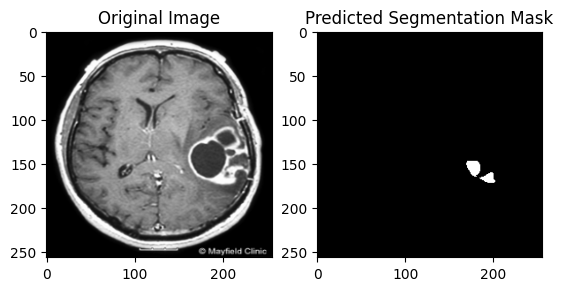

In [ ]:
# Load the U-Net model and weights
model = unet((256, 256, 3))
model.load_weights('/content/files/model.h5')  # Replace with the actual path

# Load and preprocess the test image
test_image = plt.imread('/content/sick.jpg')  # Replace with the actual path
test_image =  cv2.resize(test_image, (W, H))
test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension
test_image = test_image / 255.0  # Normalize pixel values

# Make predictions

predictions = model.predict(test_image)

# Post-process the predicted mask (you might need to adjust this based on your task)
threshold = 0.5
binary_mask = (predictions > threshold).astype(np.uint8)

# Visualize the results
plt.subplot(1, 2, 1)
plt.imshow(test_image[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.title('Predicted Segmentation Mask')

plt.show()